Copyright (c) MONAI Consortium <br>
Licensed under the Apache License, Version 2.0 (the "License"); <br>
you may not use this file except in compliance with the License. <br>
You may obtain a copy of the License at <br>
http://www.apache.org/licenses/LICENSE-2.0 <br>
Unless required by applicable law or agreed to in writing, software <br>
distributed under the License is distributed on an "AS IS" BASIS, <br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. <br>
See the License for the specific language governing permissions and <br>
limitations under the License. <br>

# Super-resolution using Stable Diffusion v2 Upscalers

This tutorial illustrates how to perform **super-resolution** on medical images using Latent Diffusion Models (LDMs) [1]. The idea is that, given a low-resolution image, we train a spatial autoencoder with a latent space of the same spatial size of the low resolution, so that high resolution images are encoded into a latent space of the same size of the low resolution image. The LDM then learns how to go from **noise to a latent representation of a high resolution image**. On training and inference, the **low resolution image is concatenated to the latent**, to condition the generative process. Finally, the high resolution latent representation is decoded into a high resolution image. 

To improve the performance of our models, we will use a method called "noise conditioning augmentation" (introduced in [2] and used in Stable Diffusion v2.0 and Imagen Video [3]). During the training, we add noise to the low-resolution images using a random signal-to-noise ratio, and we condition the diffusion models on the amount of noise added. At sampling time, we use a fixed signal-to-noise ratio, representing a small amount of augmentation that aids in removing artefacts in the samples.


[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Ho et al. "Cascaded diffusion models for high fidelity image generation" https://arxiv.org/abs/2106.15282

[3] - Ho et al. "High Definition Video Generation with Diffusion Models" https://arxiv.org/abs/2210.02303

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch import nn
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler

print_config()

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpj53lse09


## Set deterministic training for reproducibility

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data and download the training set

For this tutorial, we use the head CT dataset from MedNIST.

In [14]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]

2024-09-23 09:27:05,757 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-23 09:27:05,758 - INFO - File exists: /tmp/tmpj53lse09/MedNIST.tar.gz, skipped downloading.
2024-09-23 09:27:05,759 - INFO - Non-empty folder exists in /tmp/tmpj53lse09/MedNIST, skipped extracting.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:16<00:00, 2923.68it/s]


2024-09-23 09:27:22,258 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-23 09:27:22,258 - INFO - File exists: /tmp/tmpj53lse09/MedNIST.tar.gz, skipped downloading.
2024-09-23 09:27:22,259 - INFO - Non-empty folder exists in /tmp/tmpj53lse09/MedNIST, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:01<00:00, 2964.04it/s]


## Prepare dataloaders

Here, we create the data loader that we will use to train our models. We will use data augmentation and create low-resolution images using MONAI's transformations:

1. `LoadImaged`: to load the images
2. `EnsureChannelFirstd`: to make sure there is a channel dimension at the beginning of the output tensor
3. `ScaleIntensityRanged`: normalise the images
4. `RandAffined`: affine augmentation (just training)
5. `CopyItemd`: we copy the image item to obtain the low-resolution representation
6. `Resized`: we resize the low resolution image (copy we just made) to obtain a low resolution representation to 16x16

In [37]:
image_size = 64

# Transforms
all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    transforms.RandAffined(
        keys=["image"],
        rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
        translate_range=[(-1, 1), (-1, 1)],
        scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
        spatial_size=[image_size, image_size],
        padding_mode="zeros",
        prob=0.5,
    ),
    transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
    transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
]

train_transforms = transforms.Compose(all_transforms)
val_transforms = transforms.Compose(all_transforms[:3] + all_transforms[4:])

# Datasets
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=4)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:01<00:00, 804.53it/s]


### Visualise examples from the training set

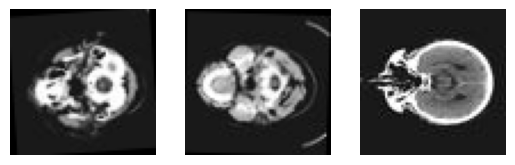

In [17]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

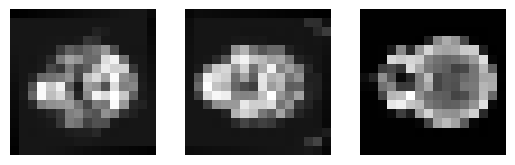

In [18]:
# Plot 3 examples from the training set in low resolution
fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(3):
    ax[i].imshow(check_data["low_res_image"][i, 0, :, :], cmap="gray")
    ax[i].axis("off")

## Define the autoencoder network and training components

To yield a 16x16 latent representation from the high-resolution images, we use AutoencoderKL. We train it using a Patch-GAN adversarial loss, as well as a perceptual loss, to boost image fidelity.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [21]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(256, 512, 512),
    latent_channels=3,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [24]:
discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, channels=64)
discriminator = discriminator.to(device)
adv_loss = PatchAdversarialLoss(criterion="least_squares")

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

In [28]:
scaler_g = GradScaler("cuda")
scaler_d = GradScaler("cuda")

## Train Autoencoder

In this section, we train a spatial autoencoder to learn how to compress high-resolution images into a latent space representation. We need to ensure that the latent space spatial shape matches that of the low resolution images.

In [30]:
# Loss weights
perceptual_weight = 0.002
adv_weight = 0.005
kl_weight = 1e-6

# Optimizers
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=5e-5)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

epoch 0/75:,recons loss: 0.153782,perc_epoch_loss: 0.505703,kl_epoch_loss: 2163.503702,
Validation. recons loss: 0.002920,


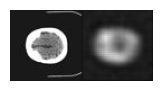

epoch 5/75:,recons loss: 0.055186,perc_epoch_loss: 0.259082,kl_epoch_loss: 2720.869604,
epoch 10/75:,recons loss: 0.047029,perc_epoch_loss: 0.211522,kl_epoch_loss: 2314.558471,
Validation. recons loss: 0.001608,


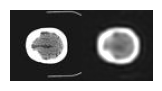

epoch 15/75:,recons loss: 0.042698,perc_epoch_loss: 0.174223,kl_epoch_loss: 2112.795490,,gen_loss: 1.012134,disc_loss: 0.002280,
epoch 20/75:,recons loss: 0.035483,perc_epoch_loss: 0.102338,kl_epoch_loss: 2271.543911,,gen_loss: 1.012229,disc_loss: 0.002381,
Validation. recons loss: 0.001392,


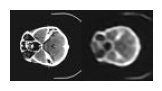

epoch 25/75:,recons loss: 0.030027,perc_epoch_loss: 0.057049,kl_epoch_loss: 2255.536555,,gen_loss: 1.012236,disc_loss: 0.012159,
epoch 30/75:,recons loss: 0.025783,perc_epoch_loss: 0.041187,kl_epoch_loss: 2198.212172,,gen_loss: 0.993313,disc_loss: 0.022697,
Validation. recons loss: 0.000970,


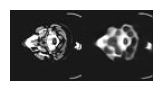

epoch 35/75:,recons loss: 0.026168,perc_epoch_loss: 0.023821,kl_epoch_loss: 2140.541582,,gen_loss: 0.633519,disc_loss: 0.151763,
epoch 40/75:,recons loss: 0.025719,perc_epoch_loss: 0.017355,kl_epoch_loss: 2062.614804,,gen_loss: 0.479063,disc_loss: 0.183541,
Validation. recons loss: 0.000736,


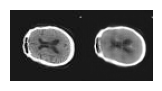

epoch 45/75:,recons loss: 0.024476,perc_epoch_loss: 0.015675,kl_epoch_loss: 1969.286549,,gen_loss: 0.510046,disc_loss: 0.174579,
epoch 50/75:,recons loss: 0.023567,perc_epoch_loss: 0.014090,kl_epoch_loss: 1853.637946,,gen_loss: 0.489276,disc_loss: 0.174202,
Validation. recons loss: 0.000862,


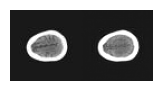

epoch 55/75:,recons loss: 0.022395,perc_epoch_loss: 0.012438,kl_epoch_loss: 1734.904024,,gen_loss: 0.462214,disc_loss: 0.178832,
epoch 60/75:,recons loss: 0.021742,perc_epoch_loss: 0.012144,kl_epoch_loss: 1622.974387,,gen_loss: 0.528392,disc_loss: 0.165096,
Validation. recons loss: 0.000838,


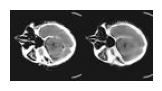

epoch 65/75:,recons loss: 0.021505,perc_epoch_loss: 0.011629,kl_epoch_loss: 1531.166383,,gen_loss: 0.506063,disc_loss: 0.167129,
epoch 70/75:,recons loss: 0.020647,perc_epoch_loss: 0.010862,kl_epoch_loss: 1449.738802,,gen_loss: 0.516405,disc_loss: 0.174172,
Validation. recons loss: 0.000698,


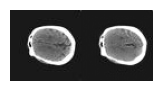

In [38]:
max_epochs = 75
val_interval = 10
print_interval = 5
autoencoder_warm_up_n_epochs = 10

for epoch in range(max_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    perc_epoch_loss = 0
    kl_epoch_loss = 0

    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)
            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            with autocast("cuda", enabled=True):
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        perc_epoch_loss += p_loss.item()
        kl_epoch_loss += kl_loss.item()

        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

    if epoch % print_interval == 0:
        msgs = [
            f"epoch {epoch:d}/{max_epochs:d}:",
            f"recons loss: {epoch_loss / len(train_loader) :4f},"
            f"perc_epoch_loss: {perc_epoch_loss / len(train_loader):4f},"
            f"kl_epoch_loss: {kl_epoch_loss / len(train_loader):4f},",
        ]

        if epoch > autoencoder_warm_up_n_epochs:
            msgs += [
                f"gen_loss: {gen_epoch_loss / len(train_loader):4f},"
                f"disc_loss: {disc_epoch_loss / len(train_loader):4f},"
            ]

        print(",".join(msgs))

    if epoch % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        msgs = f"Validation. recons loss: {recons_loss / len(val_loader) :4f},"
        print(msgs)

        # Plot reconstruction
        plt.figure(figsize=(2, 2))
        plt.imshow(torch.cat([images[0, 0].cpu(), reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()


del discriminator
del perceptual_loss
torch.cuda.empty_cache()

## Rescaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) became crucial in image-to-image translation models (such as the ones used for super-resolution). For this reason, we will compute the component-wise standard deviation to be used as scaling factor.

In [41]:
with torch.no_grad():
    with autocast("cuda", enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.8571630120277405


## Train Diffusion Model

In order to train the diffusion model to perform super-resolution, we will need to **concatenate the latent representation of the high-resolution with the low-resolution image**. Therefore, the number of input channels to the diffusion model will be the sum of the number of channels in the low-resolution (1) and the number of channels of the high-resolution image latent representation (3). In this case,  we create a Diffusion model with `in_channels=4`. Since only the output latent representation is interesting, we set `out_channels=3`. 

**At inference time** we do not have a high-resolution image. Instead, we pass the concatenation of the low resolution image, and noise of the same shape as the latent space representation.

In [42]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=3,
    num_res_blocks=2,
    channels=(256, 256, 512, 1024),
    attention_levels=(False, False, True, True),
    num_head_channels=(0, 0, 64, 64),
)
unet = unet.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

As mentioned, we will use the conditioned augmentation (introduced in [2] section 3 and used on Stable Diffusion Upscalers and Imagen Video [3] Section 2.5) as it has been shown critical for cascaded diffusion models, as well for super-resolution tasks. For this, we apply Gaussian noise augmentation to the low-resolution images. We will use a scheduler `low_res_scheduler` to add this noise, with the `t` step defining the signal-to-noise ratio and use the `t` value to condition the diffusion model (inputted using `class_labels` argument).

In [43]:
low_res_scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
max_noise_level = 350

Validation loss: 0.005906,


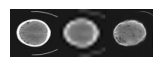

epoch 20/200:,loss: 0.144559,
Validation loss: 0.004613,


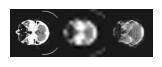

Validation loss: 0.004093,


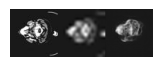

Validation loss: 0.004793,


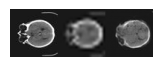

Validation loss: 0.004594,


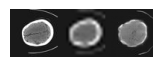

Validation loss: 0.004505,


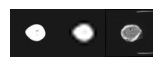

Validation loss: 0.004176,


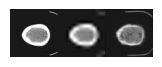

Validation loss: 0.004405,


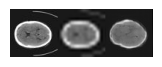

Validation loss: 0.004649,


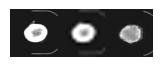

Validation loss: 0.004160,


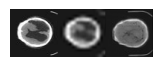

In [46]:
# Optimizers
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)

scaler_diffusion = GradScaler("cuda")

max_epochs = 200
val_interval = 20
print_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []

for epoch in range(max_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        low_res_image = batch["low_res_image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            with torch.no_grad():
                latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

            # Noise augmentation
            noise = torch.randn_like(latent).to(device)
            low_res_noise = torch.randn_like(low_res_image).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device).long()
            low_res_timesteps = torch.randint(
                0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
            ).long()

            noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )
            # Here we concatenate the HR latent and thje low resolution image.
            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler_diffusion.scale(loss).backward()
        scaler_diffusion.step(optimizer)
        scaler_diffusion.update()

        epoch_loss += loss.item()

    msgs = [f"epoch {epoch:d}/{max_epochs:d}:", f"loss: {epoch_loss / len(train_loader) :4f},"]

    if epoch % print_interval == 0:
        print(",".join(msgs))

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if epoch % val_interval == 0:
        unet.eval()
        val_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            low_res_image = batch["low_res_image"].to(device)

            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor
                    # Noise augmentation
                    noise = torch.randn_like(latent).to(device)
                    low_res_noise = torch.randn_like(low_res_image).to(device)
                    timesteps = torch.randint(
                        0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
                    ).long()
                    low_res_timesteps = torch.randint(
                        0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
                    ).long()

                    noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                    noisy_low_res_image = scheduler.add_noise(
                        original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
                    )

                    latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)
                    noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
                    loss = F.mse_loss(noise_pred.float(), noise.float())

            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_epoch_loss_list.append(val_loss)
        msgs = f"Validation loss: {val_loss / len(val_loader) :4f},"
        print(msgs)

        # Sampling image during training
        sampling_image = low_res_image[0].unsqueeze(0)
        latents = torch.randn((1, 3, 16, 16)).to(device)
        low_res_noise = torch.randn((1, 1, 16, 16)).to(device)
        noise_level = 20
        noise_level = torch.Tensor((noise_level,)).long().to(device)
        noisy_low_res_image = scheduler.add_noise(
            original_samples=sampling_image,
            noise=low_res_noise,
            timesteps=torch.Tensor((noise_level,)).long().to(device),
        )

        scheduler.set_timesteps(num_inference_steps=1000)
        for t in scheduler.timesteps:
            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                    noise_pred = unet(
                        x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level
                    )
                latents, _ = scheduler.step(noise_pred, t, latents)

        with torch.no_grad():
            decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

        low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

### Plotting sampling example

As mentioned above, at inference time, we only need to pass noise of the same shape of the latent concatenated to the low-resolution image, to get the latent representation of the corresponding high-resolution image.

In [47]:
# Sampling image during training
unet.eval()
num_samples = 3
validation_batch = first(val_loader)

images = validation_batch["image"].to(device)
sampling_image = validation_batch["low_res_image"].to(device)[:num_samples]

In [49]:
latents = torch.randn((num_samples, 3, 16, 16)).to(device)
low_res_noise = torch.randn((num_samples, 1, 16, 16)).to(device)
noise_level = 10
noise_level = torch.Tensor((noise_level,)).long().to(device)
noisy_low_res_image = scheduler.add_noise(
    original_samples=sampling_image, noise=low_res_noise, timesteps=torch.Tensor((noise_level,)).long().to(device)
)
scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast("cuda", enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = unet(x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level)

        # 2. compute previous image: x_t -> x_t-1
        latents, _ = scheduler.step(noise_pred, t, latents)

with torch.no_grad():
    decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.22it/s]


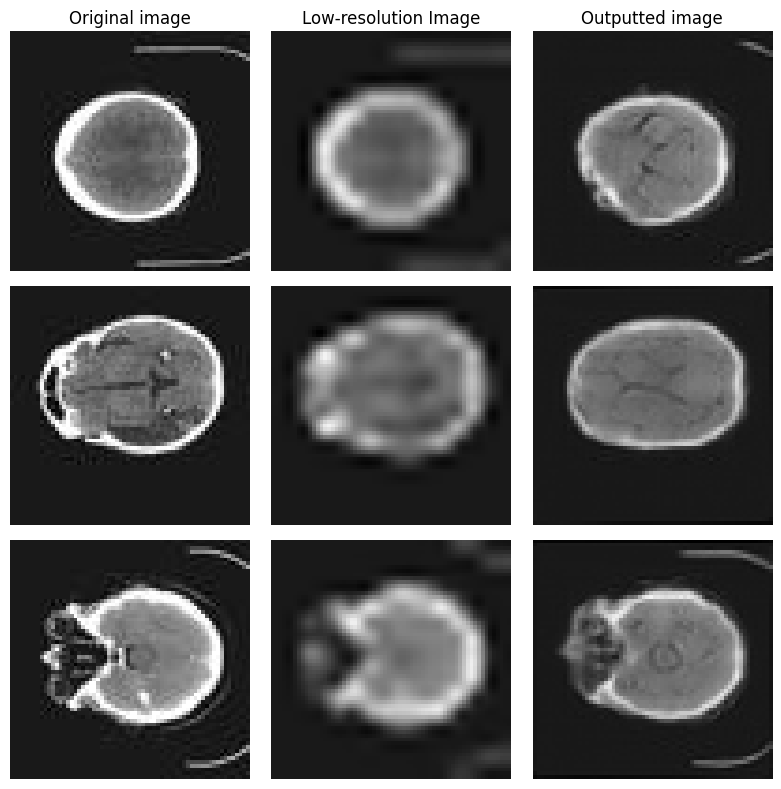

In [50]:
low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")
for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")
plt.tight_layout()

### Clean-up data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)